## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import Input, Model, backend as K
import numpy as np
import matplotlib.pyplot as plt
print("Tensorflow version: ", tf.__version__)
from IPython.display import display

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

import time

# Needed for saving on drive or locally
import pandas as pd
from google.colab import drive

# Enable the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)

print("All devices: ", *tf.config.list_logical_devices("TPU"), sep="\n\t")

Tensorflow version:  2.12.0
All devices: 
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')


## MNIST Examples from keras

In [2]:
batch_size = 128
num_classes = 10 # 0,1,...., 9. The digits
epochs = 20 # Number of runs

Batch size defines the number of samples that will be propagated through the network. If you have 1050 training samples
then our algorithm will take in the training samples in batches, where each batch has the same size. However, it must
be the case that the number of samples is divisible by the batch_size, else we have batches with fractional instances,
these do not exist.

In addition, there are some advantages of using a batch size that is smaller than the total number of training samples:
* We require less memory to be used. By training with fewer sampling, the overall training prodedure takes less memory.
* Typically, networks train faster with mini-batches as opposed to the entire batch of all instances. This is a consequence of how weights are adjusted after each propagation.

Disadvantages:
* The smaller the batches, the less accurate the estimate of the gradient will be.

In [6]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [9]:
# Model initialization and fitting
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,))) # input layer
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu')) # layer 1
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax') ) # final layer, output

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'], steps_per_execution=128)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 512)               401920    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
235/235 [============================

In [11]:

# Change epoch (default)
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Create CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          # batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
1875/1875 [==============================] - 36s 18ms/step - loss: 2.2117 - accuracy: 0.2341 - val_loss: 2.0780 - val_accuracy: 0.5652
Epoch 2/12
1875/1875 [==============================] - 35s 18ms/step - loss: 1.9421 - accuracy: 0.4870 - val_loss: 1.6824 - val_accuracy: 0.7627
Epoch 3/12
1875/1875 [==============================] - 35s 18ms/step - loss: 1.5482 - accuracy: 0.6172 - val_loss: 1.2208 - val_accuracy: 0.8078
Epoch 4/12
1875/1875 [==============================] - 35s 18ms/step - loss: 1.2019 - accuracy: 0.6776 - val_loss: 0.8863 - val_accuracy: 0.8341
Epoch 5/12
1875/1875 [==============================] - 34s 18ms/step - loss: 0.9859 - accuracy: 0.7157 - val_loss: 0.6960 - val_accuracy: 0.8517
Epoch 6/12
1875/1875 [==============================] - 35s 18ms/step - loss: 0.8464 - accuracy: 0.7499 - val_loss: 0.5828 - val_accuracy: 0.8647
Epoch 7/12
1875/1875 [=============================

## MNIST Fashion - Exercise 1.2

In [ ]:
# Load in data
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
y_train_full

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
# y_train_full.shape
X_train_full.shape

(60000, 28, 28)

In [ ]:
# X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
# y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
# For the fashion list we have different labels than the MNIST digits:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

#### Example of an instance

Dress


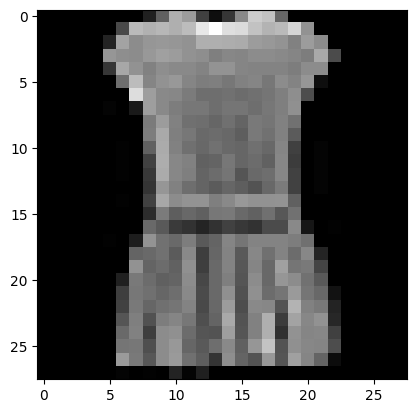

In [ ]:
# Example of instance 4
print(class_names[y_train_full[3]])
plt.imshow(X_train_full[3,:,:], cmap='gray')
plt.show()



# Back to the exercise:
## Build the MLP neural network!


In [ ]:
# Build the network layer by layer, in a SEQUENCE -> sequential
model = keras.models.Sequential()

""" Add the first layer, the input layer.

It converts each input image into a 1D array: if it receives input data X, it
computes X.reshape(-1, 1). This layer does not have any parameters; it is just
there to do some simple preprocessing. Since it is the first layer in the model, you
should specify the input_shape, which doesn’t include the batch size, only the
shape of the instances. """

model.add(keras.layers.Flatten(input_shape=[28, 28], name="InputLayer"))

# Add layer with 300 neurons. Each Dense layer manages its own weight matrix, containing all the
# connection weights between the neurons and their inputs.

model.add(keras.layers.Dense(300, activation="relu", name="HiddenLayer1"))

# And another layer, with 100 neurons
model.add(keras.layers.Dense(100, activation="relu", name="HiddenLayer2"))

# The final layer, the output layer, we have 10 classes, so we need 10 neurons, 1 per class.
# We use softmax as all classes are exclusive.

""" The network is configured to output N values, one for each class in the classification
task, and the softmax function is used to normalize the outputs, converting them from
weighted sum values into probabilities that sum to one. Each value in the output of the
softmax function is interpreted as the probability of membership for each class."""

model.add(keras.layers.Dense(10, activation="softmax", name="OutputLayer"))

#### Model in one sequence:

In [ ]:
# it is also possible to do it in one go:
"""
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
        ])
"""

#### Visualize our model:

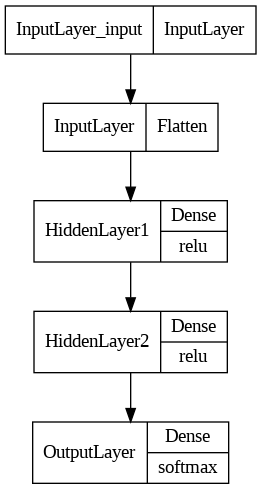

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Flatten)        (None, 784)               0         
                                                                 
 HiddenLayer1 (Dense)        (None, 300)               235500    
                                                                 
 HiddenLayer2 (Dense)        (None, 100)               30100     
                                                                 
 OutputLayer (Dense)         (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Image of our model - useful if we have named layers

display(keras.utils.plot_model(model, show_layer_activations=True))

# Or summary
model.summary()



The output shape can have None. This implies that the batch size can be anything.

### Run the NN:

In [ ]:
""" We have sparse labels (i.e., for each instance, there is just a target
class index, from 0 to 9 in this case), and the classes are exclusive.

Regarding the optimizer, "sgd" means that we will train the model using
simple Stochastic Gradient Descent.

As we are using a TPU, we can adjust the steps_per_execution. This
makes the running and calculating of the weights from our NN sufficiently
faster.
"""

# Choose an optimizer from keras.optimizers.X
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=[["accuracy"], ["mse"]], steps_per_execution=100)

# Training and evaluation - epochs is the number of runs
history = model.fit(X_train_full / 255.0, y_train_full, epochs=30,
                    validation_split=0.1, batch_size=64, verbose=0) # verbose=0 is stfu

#### Plot the curves of loss, accuracy, validation loss and validation accuracy:

In [ ]:
import pandas as pd

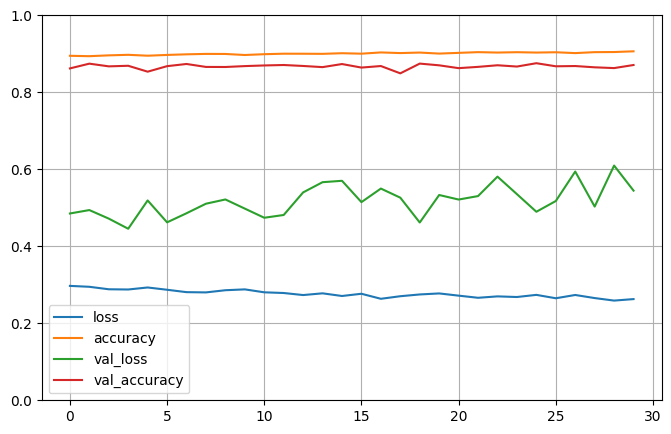

'the validation curves are close to the training curves, which means\nthat there is not too much overfitting '

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

"""the validation curves are close to the training curves, which means
that there is not too much overfitting """

## Evaluate the model:

In [ ]:
y_test.shape

(10000,)

In [ ]:
model.evaluate(X_test, y_test, batch_size=64, verbose=1)

157/157 [==============================] - 0s 3ms/step - loss: 354.4655 - accuracy: 0.8326 - mse: 27.6995


[354.46551513671875, 0.8325999975204468, 27.69953727722168]

# Make functions that can make arbitrary Neural Networks. In addition, make a function that can fit the model, as well as another function that can evaluate the model.

In [ ]:
def make_model(arch, optimizer,
               metrics: list = ["accuracy"],
               steps_per_execution: int = 1,
               summary_model: bool = False):

  # Create a dictionary of possible layers. In this case we can create any arbitary network
  # without having to constantly copy and paste lines.
  layer_dict = {
        "dense": Dense,             # units, activation=None
        "dropout": Dropout,         # rate, noise_shape=None, seed=None
        "conv": Conv2D,             # filters, kernel_size, strides=(1, 1), padding="valid", activation=None
        "maxpooling": MaxPooling2D, # pool_size=(2, 2), strides=None, padding="valid"
        "flatten": Flatten,
        "BN": BatchNormalization,
  }

  ##########################################

  # Initiate model
  model = keras.models.Sequential()

  ## Add input layer
  model.add(Input(shape=arch['shape'][0]))

  ## Add layers
  for layer, kwargs in arch['layers']:
    # Use our dictionary to obtain the callable layer and put in the keywords arguments
    model.add(layer_dict[layer](**kwargs))

  # Output layer
  model.add(layer_dict[arch['output'][0]](**arch['output'][1]))

  ##########################################

  # Print summary if wanted
  if summary_model:
    model.summary()

  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=metrics,
                steps_per_execution=steps_per_execution)

  # Return model before fitting
  return model


def fit_model(model, X_train, y_train, scaling,
              epochs: int = 30, validation_split: float = 0.1,
              batch: int = 64, verbose: int = 0):

  history = model.fit(X_train/scaling, y_train, epochs=epochs,
                    validation_split = validation_split, batch_size=batch, verbose=verbose) # verbose=0 is stfu

  return history


def eval_model(model, X_test, y_test, batch, verbose=1):
  return model.evaluate(X_test, y_test, batch_size=batch, verbose=verbose)



# MLP case:

### Define the multi layer perceptron architecture:

In [ ]:
mlp_arch = {
    'shape': (28*28, 10), # input, output
    'output': ('dense', {'units': 10, 'activation': 'softmax'}), # output layer
    'layers': [
         ('flatten', {}),
        ('dense', {'units':300, 'activation': 'relu'}),
        ('dense', {'units':100, 'activation': 'relu'}),
        ]
}

### Test run:

In [ ]:
mod = make_model(mlp_arch, keras.optimizers.Adam(learning_rate=0.001),
                 steps_per_execution=100, summary_model=True)

# display(keras.utils.plot_model(mod, show_layer_activations=True))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 300)               235500    
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                                 
 dense_14 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trainedmodel1 = fit_model(mod, X_train_full.reshape(60000, 784), y_train_full, 255.0,
                          verbose=1)

# X_train_full.reshape(60000, 784).shape


Epoch 1/30
844/844 [==============================] - 3s 4ms/step - loss: 0.4948 - accuracy: 0.8264 - val_loss: 0.3913 - val_accuracy: 0.8628
Epoch 2/30
844/844 [==============================] - 1s 2ms/step - loss: 0.3644 - accuracy: 0.8675 - val_loss: 0.3603 - val_accuracy: 0.8677
Epoch 3/30
844/844 [==============================] - 1s 2ms/step - loss: 0.3270 - accuracy: 0.8797 - val_loss: 0.3504 - val_accuracy: 0.8690
Epoch 4/30
844/844 [==============================] - 1s 2ms/step - loss: 0.3051 - accuracy: 0.8878 - val_loss: 0.3248 - val_accuracy: 0.8785
Epoch 5/30
844/844 [==============================] - 1s 2ms/step - loss: 0.2872 - accuracy: 0.8938 - val_loss: 0.3543 - val_accuracy: 0.8682
Epoch 6/30
844/844 [==============================] - 1s 2ms/step - loss: 0.2696 - accuracy: 0.8995 - val_loss: 0.3282 - val_accuracy: 0.8795
Epoch 7/30
844/844 [==============================] - 1s 2ms/step - loss: 0.2577 - accuracy: 0.9032 - val_loss: 0.3279 - val_accuracy: 0.8788
Epoch 

In [ ]:
X_train_full.reshape(60000, 784).shape

(60000, 784)

Evaluate our NN:

In [ ]:
eval_model(mod, X_test.reshape(10000, 784), y_test, batch=64, verbose=1)

157/157 [==============================] - 1s 4ms/step - loss: 89.0022 - accuracy: 0.8660


[89.0022201538086, 0.8659999966621399]

## Time to scale up, we want to now analyse which optimizer, learning rate, batch size and epoch number give us the highest accuracy for the MNIST fashion dataset, given our MLP.

In [ ]:
optimizers = [
     # Keyword arguments (kwargs) come in dictionaries ('{}')
      (keras.optimizers.Adam, {'learning_rate': 0.001}),
      # (keras.optimizers.Adam, {learning_rate=0.002}), (keras.optimizers.Adam, {learning_rate=0.003}),
      # (keras.optimizers.Adam, {learning_rate=0.004}), (keras.optimizers.Adam, {learning_rate=0.005}),




      # (keras.optimizers.Adadelta, {}),
      (keras.optimizers.Adagrad, {}),
      (keras.optimizers.Adamax, {'learning_rate': 0.001}),# (keras.optimizers.Adamax,  {'learning_rate': 0.002}), #(keras.optimizers.Adamax,  {'learning_rate': 0.003}),
      # (keras.optimizers.Ftrl,{}),
      (keras.optimizers.Nadam,{}),
      (keras.optimizers.RMSprop, {}),
      # (keras.optimizers.SGD, {})

      ]

accuracies = np.empty((0, 4))
for optimizer, kwarg in optimizers:
  # print(optimizer.__name__, kwarg)
  model1 = make_model(mlp_arch, optimizer=optimizer(**kwarg),
           steps_per_execution=100, summary_model=False)

  fit_model(model1, X_train_full.reshape(60000, 784), y_train_full, 255.0,
                          verbose=0)

  accuracies = np.append(accuracies, np.array([f"Name: {optimizer.__name__}",
                                               f"Kwargs: {kwarg}", "Accuracy:", eval_model(model1, X_test.reshape(10000, 784), y_test, batch=64, verbose=0)[1]]).reshape(1, -1), axis=0)






In [ ]:
print(accuracies[:,-1])
best = np.argmax(np.array([float(i) for i in accuracies[:,-1]]))
print("Best model:", accuracies[:,0][best], accuracies[:,1][best], accuracies[:,2][best], accuracies[:,-1][best])


# if we have different models:
#display(keras.utils.plot_model(model, show_layer_activations=True))

['0.8654000163078308' '0.828000009059906' '0.8636000156402588'
 '0.8726999759674072' '0.8712000250816345']
Best model: Name: Nadam Kwargs: {} Accuracy: 0.8726999759674072


## Test architectures, optimizers, batch sizes and epochs for any given choice:

In [ ]:
def test_networks(models, optimizers, batch_sizes, epochs):

  results = np.empty((0,5))

  for model in models:
    for optimizer, kwarg in optimizers:
      model1 = make_model(model, optimizer=optimizer(**kwarg),
           steps_per_execution=100, summary_model=False)

      for batch in batch_sizes:
        for epoch in epochs:
          fit_model(model1, X_train_full.reshape(60000, 784), y_train_full, 255.0, epochs=epoch,
                            verbose=0, batch=batch, validation_split=0.1)

          accuracy = eval_model(model1, X_test.reshape(10000, 784), y_test, batch=batch, verbose=0)[1]

          results = np.append(results, np.array([f"{optimizer.__name__ = }", f"{kwarg = }",
                                                      f"{batch = }",f"{epoch = }", f"{accuracy = }"]).reshape(1, -1), axis=0)


    return results

### Results of regular MLP architecture:

In [ ]:
results1 = test_networks(
      [mlp_arch],
       [
     # Keyword arguments (kwargs) come in dictionaries ('{}')

      (keras.optimizers.Adam, {'learning_rate': 0.0005}), #(keras.optimizers.Adam, {'learning_rate': 0.001}), (keras.optimizers.Adam, {'learning_rate':0.002}),
      (keras.optimizers.Adadelta, {'learning_rate': 0.001}),
      (keras.optimizers.Adagrad, {'learning_rate': 0.001}),
      (keras.optimizers.Adamax, {'learning_rate': 0.0005}),# (keras.optimizers.Adamax,  {'learning_rate': 0.001}), (keras.optimizers.Adamax,  {'learning_rate': 0.002}),
      # (keras.optimizers.Ftrl,{}),
      (keras.optimizers.Nadam,{'learning_rate': 0.0005}),# (keras.optimizers.Nadam,{'learning_rate': 0.001}), (keras.optimizers.Nadam,{'learning_rate': 0.002}),
      (keras.optimizers.RMSprop, {'learning_rate': 0.001}),
      (keras.optimizers.SGD, {'learning_rate': 0.001})

      ],

      batch_sizes=[64], epochs = [10]

)

In [ ]:
# Find the best model:

accuracies = [float(i.split('=')[1].strip()) for i in results1[:,-1]]
best = np.argmax(np.array([accuracies]))

print("Best model:", "\n")
for i in np.arange(results1.shape[-1]):
  print(results1[:,i][best])


Best model: 

optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 64
epoch = 10
accuracy = 0.8679999709129333


In [ ]:
results = [np.argsort(accuracies)[:][::-1]][0] # [::-1] is for reverse order, such that the highest accuracy is value 1 in the top5

for i in results:
  print("\nModel:")
  for j in np.arange(results1.shape[-1]):
    print(results1[:,j][i])



Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 64
epoch = 10
accuracy = 0.8679999709129333

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 64
epoch = 10
accuracy = 0.8671000003814697

Model:
optimizer.__name__ = 'RMSprop'
kwarg = {'learning_rate': 0.001}
batch = 64
epoch = 10
accuracy = 0.8662999868392944

Model:
optimizer.__name__ = 'Adamax'
kwarg = {'learning_rate': 0.0005}
batch = 64
epoch = 10
accuracy = 0.8436999917030334

Model:
optimizer.__name__ = 'Adagrad'
kwarg = {'learning_rate': 0.001}
batch = 64
epoch = 10
accuracy = 0.8105999827384949

Model:
optimizer.__name__ = 'SGD'
kwarg = {'learning_rate': 0.001}
batch = 64
epoch = 10
accuracy = 0.7811999917030334

Model:
optimizer.__name__ = 'Adadelta'
kwarg = {'learning_rate': 0.001}
batch = 64
epoch = 10
accuracy = 0.7074999809265137


#### Full output:

In addition, the full ouput of results1 was:

      ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 32',
        'epoch = 30', 'accuracy = 0.8683000206947327']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 64',
        'epoch = 5', 'accuracy = 0.8709999918937683']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 64',
        'epoch = 10', 'accuracy = 0.8736000061035156']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 64',
        'epoch = 20', 'accuracy = 0.8697999715805054']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 64',
        'epoch = 30', 'accuracy = 0.873199999332428']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 128',
        'epoch = 5', 'accuracy = 0.8690999746322632']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 128',
        'epoch = 10', 'accuracy = 0.8729000091552734']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 128',
        'epoch = 20', 'accuracy = 0.871999979019165']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 128',
        'epoch = 30', 'accuracy = 0.8683000206947327']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 256',
        'epoch = 5', 'accuracy = 0.8734999895095825']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 256',
        'epoch = 10', 'accuracy = 0.8725000023841858']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 256',
        'epoch = 20', 'accuracy = 0.866599977016449']

       ["optimizer.__name__ = 'RMSprop'", 'kwarg = {}', 'batch = 256',
        'epoch = 30', 'accuracy = 0.8697999715805054']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 32',
        'epoch = 5', 'accuracy = 0.8222000002861023']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 32',
        'epoch = 10', 'accuracy = 0.8388000130653381']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 32',
        'epoch = 20', 'accuracy = 0.8525999784469604']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 32',
        'epoch = 30', 'accuracy = 0.8587999939918518']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 64',
        'epoch = 5', 'accuracy = 0.843500018119812']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 64',
        'epoch = 10', 'accuracy = 0.8406000137329102']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 64',
        'epoch = 20', 'accuracy = 0.8314999938011169']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 64',
        'epoch = 30', 'accuracy = 0.8364999890327454']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 128',
        'epoch = 5', 'accuracy = 0.848800003528595']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 128',
        'epoch = 10', 'accuracy = 0.8391000032424927']

       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 128',
        'epoch = 20', 'accuracy = 0.8314999938011169']
        
       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 128',
        'epoch = 30', 'accuracy = 0.8317999839782715']
        
       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 256',
        'epoch = 5', 'accuracy = 0.8378000259399414']
        
       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 256',
        'epoch = 10', 'accuracy = 0.8388000130653381']
        
       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 256',
        'epoch = 20', 'accuracy = 0.8361999988555908']
        
       ["optimizer.__name__ = 'SGD'", 'kwarg = {}', 'batch = 256',
        'epoch = 30', 'accuracy = 0.8353000283241272']
       

#### Let's go again, this time using different epochs and batch sizes:

In [ ]:
def Top5(results):
  accuracies = [float(i.split('=')[1].strip()) for i in results[:,-1]]
  top5 = [np.argsort(accuracies)[-5:][::-1]][0] # [::-1] is for reverse order, such that the highest accuracy is value 1 in the top5

  for i in top5:
    print("\nModel:")
    for j in np.arange(results.shape[-1]):
      print(results[:,j][i])

In [ ]:
results2 = test_networks(
      [mlp_arch],

    [

     ## Keyword arguments (kwargs) come in dictionaries ('{}') ##

      (keras.optimizers.Adam, {'learning_rate': 0.0005}), (keras.optimizers.Adam, {'learning_rate': 0.001}), (keras.optimizers.Adam, {'learning_rate':0.002}),

      (keras.optimizers.Adagrad, {'learning_rate': 0.001}),
      (keras.optimizers.Adamax, {'learning_rate': 0.0005}), (keras.optimizers.Adamax,  {'learning_rate': 0.001}), (keras.optimizers.Adamax,  {'learning_rate': 0.002}),
      (keras.optimizers.Nadam,{'learning_rate': 0.0005}), (keras.optimizers.Nadam,{'learning_rate': 0.001}), (keras.optimizers.Nadam,{'learning_rate': 0.002}),
      (keras.optimizers.RMSprop, {'learning_rate': 0.001}),


    ],

      batch_sizes=[32, 64, 128, 256], epochs = [5, 10, 20, 30]
)

In [ ]:
Top5(results2)


Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 32
epoch = 10
accuracy = 0.8858000040054321

Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 30
accuracy = 0.8834999799728394

Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 128
epoch = 10
accuracy = 0.8827000260353088

Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 20
accuracy = 0.8826000094413757

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 30
accuracy = 0.882099986076355


### Two scenario's:
* remove the 300 nodes layer, rerun the calculation.
* also try adding a layers of dropout to the original network. Add dropout between the last layer and the output layer, as well as between the second to last and the last (regular) layer

In [ ]:
mlp_arch_rmove = {
    'shape': (28*28, 10), # input, output
    'output': ('dense', {'units': 10, 'activation': 'softmax'}), # output layer
    'layers': [
         ('flatten', {}),
        ('dense', {'units':300, 'activation': 'relu'}),
        ]
}

# dropout
mlp_arch_drop = {
    'shape': (28*28, 10), # input, output
    'output': ('dense', {'units': 10, 'activation': 'softmax'}), # output layer
    'layers': [
        ('flatten', {}),
        ('dense', {'units':300, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units':100, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ]
}


# Show models:

# display(keras.utils.plot_model(make_model(mlp_arch_rmove, optimizer=keras.optimizers.Adam(),
#            steps_per_execution=100, summary_model=True), show_layer_activations=True))

# display(keras.utils.plot_model(make_model(mlp_arch_drop, optimizer=keras.optimizers.Adam(),
#            steps_per_execution=100, summary_model=True), show_layer_activations=True))

In [ ]:
results_mlp_rmoveL = test_networks(
      [mlp_arch_rmove],

    [
      (keras.optimizers.Adam, {'learning_rate': 0.0005}), (keras.optimizers.Adam, {'learning_rate': 0.001}),
      (keras.optimizers.Nadam,{'learning_rate': 0.0005}), (keras.optimizers.Nadam,{'learning_rate': 0.001}),
    ],

      batch_sizes=[32, 64, 128, 256], epochs = [10, 20, 30]
)

In [ ]:
Top5(results_mlp_rmoveL)


Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 128
epoch = 20
accuracy = 0.8826000094413757

Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 30
accuracy = 0.8826000094413757

Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 64
epoch = 10
accuracy = 0.8819000124931335

Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 128
epoch = 30
accuracy = 0.8819000124931335

Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 10
accuracy = 0.8815000057220459


Remark: we see that removing a layer lowers our final accuracy. In this case, our highest scoring model is about equivalent to the model of position 5 for the original model. It shows that we lose performance by removing de 100 nodes layer.

In [ ]:
## Using the dropout model:
results_mlp_dropout = test_networks([mlp_arch_drop],
                       [
      (keras.optimizers.Adam, {'learning_rate': 0.0005}), (keras.optimizers.Adam, {'learning_rate': 0.001}),
      (keras.optimizers.Nadam,{'learning_rate': 0.0005}), (keras.optimizers.Nadam,{'learning_rate': 0.001}),
                       ],

              batch_sizes=[32, 64, 128, 256],
                       epochs = [10, 20, 30],

                       )


In [ ]:
Top5(results_mlp_dropout)


Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 128
epoch = 20
accuracy = 0.8844000101089478

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 64
epoch = 30
accuracy = 0.879800021648407

Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 64
epoch = 20
accuracy = 0.8780999779701233

Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 10
accuracy = 0.8759999871253967

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 128
epoch = 30
accuracy = 0.8743000030517578


Remark: we see that the performance has dropped a little bit, but let's go and try again, but this time using one layer of dropout 0.5. In addition, let's just use the best hyperparameters set of the previous result to speed up the process.

In [ ]:
mlp_arch_dropout_1 = {
    'shape': (28*28, 10), # input, output
    'output': ('dense', {'units': 10, 'activation': 'softmax'}), # output layer
    'layers': [
        ('flatten', {}),
        ('dense', {'units':300, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units':100, 'activation': 'relu'}),
        ]
}


results_mlp_dropout_1 = test_networks([mlp_arch_dropout_1],
                       [
      (keras.optimizers.Adam, {'learning_rate': 0.0005}),
      (keras.optimizers.Nadam,{'learning_rate': 0.0005}),
                       ],

              batch_sizes=[64, 128, 256],
                       epochs = [10, 20, 30],

                       )

Top5(results_mlp_dropout_1)


Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 128
epoch = 30
accuracy = 0.8884999752044678

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 20
accuracy = 0.8862000107765198

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 64
epoch = 30
accuracy = 0.8853999972343445

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 10
accuracy = 0.8849999904632568

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 30
accuracy = 0.8845000267028809


### Another case, use the dropout model together with regularization.

About L1 and L2 regularization: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c .

We use L1 regularization for the layers with the largest number of nodes. L1 regularization helps in order to penalize for a large number of features.

In [ ]:
# , kernel_regularizer='l1'
mlp_arch_l1_drop = {
    'shape': (28*28, 10), # input, output
    'output': ('dense', {'units': 10, 'activation': 'softmax'}), # output layer
    'layers': [
         ('flatten', {}),
        ('dense', {'units':300, 'activation': 'relu', 'kernel_regularizer': 'l1'}),
         ('dropout', {'rate': 0.5}),
        ('dense', {'units':100, 'activation': 'relu'}),
        ]
}

# display(keras.utils.plot_model(make_model(mlp_arch_l1_drop, optimizer=keras.optimizers.Adam(),
#            steps_per_execution=100, summary_model=True), show_layer_activations=True))

In [ ]:
results_mlp_L1_dropout = test_networks([mlp_arch_l1_drop],
                       [
      (keras.optimizers.Adam, {'learning_rate': 0.0005}),
      (keras.optimizers.Nadam,{'learning_rate': 0.0005}),
                       ],

              batch_sizes=[64, 128, 256],
                       epochs = [10, 20, 30],

                       )

In [ ]:
Top5(results_mlp_L1_dropout)


Model:
optimizer.__name__ = 'Adam'
kwarg = {'learning_rate': 0.0005}
batch = 128
epoch = 20
accuracy = 0.7688000202178955

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 10
accuracy = 0.7547000050544739

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 128
epoch = 10
accuracy = 0.7483000159263611

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 256
epoch = 20
accuracy = 0.7409999966621399

Model:
optimizer.__name__ = 'Nadam'
kwarg = {'learning_rate': 0.0005}
batch = 64
epoch = 30
accuracy = 0.733299970626831


Remark: regularization was a BAD idea!

# Convolutional network:

#### The architecture:

In [ ]:
convolution_model ={
    'shape':((28, 28, 1), 10), # input, output (-> we have 10 classes of clothes, each with a given probability per item (returned by Softmax))
    'output': ('dense', {'units': 10, 'activation': 'softmax'}),
    'layers':[
        ('conv', {'filters':64, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'}),
        ('maxpooling', {'pool_size': (2,2)}),
        # by reducing the spacial dimensionality by two we can afford to double the filters (and thus feature maps)
        ('conv', {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('conv', {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('conv', {'filters': 256, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('conv', {'filters': 256, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('flatten', {}),
        ('dense', {'units': 128, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units': 64, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),

    ]
}

# display(keras.utils.plot_model(make_model(convolution_model, optimizer=keras.optimizers.Adam(),
#            steps_per_execution=100, summary_model=True), show_layer_activations=True))

### Let's test!

In [ ]:
# I was lazy, need to use this function above too
def test_networks_V2(models, optimizers, batch_sizes, epochs,
                     input_shape, X_train, y_train, X_test, y_test,
                     steps_per_execution: int = 100,
                     print_steps: bool = False, time_check: bool = False,
                     filename: str = None, save: bool = False):

  # Check if the file exists; if it does, load the existing data
  try:
      result_df = pd.read_csv(filename)
      print(f"Found {filename = }")
  except FileNotFoundError:
      print(f"Could not find {filename =}")
      result_df = pd.DataFrame(columns=["Name", "Kwargs", "Batch_size", "Epochs", "Accuracy"])


  for model in models:
    for optimizer, kwarg in optimizers:

      if print_steps:
        print(f"Fitting model using {optimizer.__name__ = }")



      model1 = make_model(model, optimizer=optimizer(**kwarg),
           steps_per_execution=steps_per_execution, summary_model=False)

      for batch in batch_sizes:
        for epoch in epochs:
          if print_steps:
            print(f"Epochs = {epoch}, batch size = {batch}")

          if time_check:
            start_time = time.time()

          fit_model(model1, X_train.reshape(X_train.shape[0], *input_shape), y_train, 255.0, epochs=epoch,
                            verbose=0, batch=batch, validation_split=0.1)

          accuracy = eval_model(model1, X_test.reshape(X_test.shape[0], *input_shape), y_test, batch=batch, verbose=0)[1]

          if time_check:
            print(f"Time elapsed for {optimizer.__name__ = }, {kwarg = }, {batch = }, {epoch= } is {(time.time()-start_time)/60} min")

          # Write to file
          new_data = {"Name": optimizer.__name__, "Kwargs": kwarg,
                      "Batch_size": batch, "Epochs": epoch,
                      "Accuracy": accuracy}

          # Append to the existing file
          result_df = result_df.append(new_data, ignore_index=True)

          # Save the DataFrame to a .csv file after each iteration
          if save:
            result_df.to_csv(filename, index=False)

    return result_df

#### Running for convolutional network:

In [ ]:
#df1 = pd.read_csv('IDL_A1_convolution_default.csv')

#df1[df1['Name'] == 'RMSprop']

# If you want to save:
#!cp IDL_A1_convolution_default.csv /content/drive/MyDrive/IDL/A1/IDL_A1_convolution_default.csv

# Or download locally
from google.colab import files
#files.download('IDL_A1_convolution_default.csv')

df_loaded_from_drive = pd.read_csv('/content/drive/MyDrive/IDL/A1/IDL_A1_convolution_default.csv')
df_loaded_from_drive

Idea: implement batch normalization. It speeds up the process a lot, as well as that it helps to gain higher accuracy for our model. Add Batch Normalization after a sequence of convolutions and maxpooling (this is done often in practise; found online, https://analyticsindiamag.com/everything-you-should-know-about-dropouts-and-batchnormalization-in-cnn/#:~:text=It%20can%20be%20used%20at,the%20classification%20of%20handwritten%20digits.)

In [ ]:
convolution_model_modified ={
    'shape':((28,28, 1), 10),
    'output': ('dense', {'units': 10, 'activation': 'softmax'}),
    'layers':[
        ('conv', {'filters':64, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('conv', {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('conv', {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('conv', {'filters': 256, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('conv', {'filters': 256, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('maxpooling', {'pool_size': (2,2)}),
        # New layer of batch normalization
        ('BN', {}),
        ('flatten', {}),
        ('dense', {'units': 128, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units': 64, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),

    ]
}

In [ ]:
df_CNN_BN = pd.read_csv('/content/drive/MyDrive/IDL/A1/IDL_A1_convolution_with_BN.csv')
df_CNN_BN

,Name,Kwargs,Batch_size,Epochs,Accuracy
0,Adam,{'learning_rate': 0.001},64,10,0.8499
1,Adam,{'learning_rate': 0.001},128,10,0.8220
2,Adam,{'learning_rate': 0.001},256,10,0.8377
3,Adam,{'learning_rate': 0.001},512,10,0.8284
4,Adamax,{'learning_rate': 0.001},64,10,0.8515
5,Adamax,{'learning_rate': 0.001},128,10,0.8197
6,Adamax,{'learning_rate': 0.001},256,10,0.7955
7,Adamax,{'learning_rate': 0.001},512,10,0.8010
8,Nadam,{'learning_rate': 0.001},64,10,0.8382
9,Nadam,{'learning_rate': 0.001},128,10,0.8619


Remove batch normalization and rerun the CNN with a learning rate of 0.0005.

In [ ]:
test_networks_V2([convolution_model],
                       [
                       # (keras.optimizers.Adam, {'learning_rate': 0.0005}),
                       # (keras.optimizers.Adadelta, {'learning_rate': 0.001}),
                       # (keras.optimizers.Adagrad, {'learning_rate': 0.001}),
                        (keras.optimizers.Adamax,  {'learning_rate': 0.0005}),
                       # (keras.optimizers.Nadam,{'learning_rate': 0.0005}),
                        # (keras.optimizers.RMSprop, {'learning_rate': 0.001}),
                       # (keras.optimizers.SGD, {'learning_rate': 0.001})
                       ],

                        batch_sizes = [64, 128, 256, 512],#, 128, 256, 512: too big # the larger size speeds up the process, at the cost of performance
                        epochs = [20], #5, 10, 20
                        input_shape = convolution_model['shape'][0],
                        X_train = X_train_full,
                        y_train = y_train_full,
                        X_test = X_test,
                        y_test = y_test,

                        print_steps=True,
                        time_check=True,
                        filename='/content/drive/MyDrive/IDL/A1/IDL_A1_convolution_default.csv',
                        steps_per_execution=1000,
                        save=True

                       )

Found filename = '/content/drive/MyDrive/IDL/A1/IDL_A1_convolution_default.csv'
Fitting model using optimizer.__name__ = 'Adam'
Epochs = 10, batch size = 64
Time elapsed for optimizer.__name__ = 'Adam', kwarg = {'learning_rate': 0.0005}, batch = 64, epoch= 10 is 7.223342784245809 min
Epochs = 10, batch size = 128


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Adam', kwarg = {'learning_rate': 0.0005}, batch = 128, epoch= 10 is 5.814832373460134 min
Epochs = 10, batch size = 256


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Adam', kwarg = {'learning_rate': 0.0005}, batch = 256, epoch= 10 is 5.502290268739064 min
Epochs = 10, batch size = 512


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Adam', kwarg = {'learning_rate': 0.0005}, batch = 512, epoch= 10 is 5.3646121223767596 min
Fitting model using optimizer.__name__ = 'Adamax'


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Epochs = 10, batch size = 64
Time elapsed for optimizer.__name__ = 'Adamax', kwarg = {'learning_rate': 0.0005}, batch = 64, epoch= 10 is 7.247229675451915 min
Epochs = 10, batch size = 128


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Adamax', kwarg = {'learning_rate': 0.0005}, batch = 128, epoch= 10 is 5.8362651586532595 min
Epochs = 10, batch size = 256


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Adamax', kwarg = {'learning_rate': 0.0005}, batch = 256, epoch= 10 is 5.526667745908101 min
Epochs = 10, batch size = 512


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Adamax', kwarg = {'learning_rate': 0.0005}, batch = 512, epoch= 10 is 5.373407514890035 min
Fitting model using optimizer.__name__ = 'Nadam'
Epochs = 10, batch size = 64


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Nadam', kwarg = {'learning_rate': 0.0005}, batch = 64, epoch= 10 is 7.372383244832357 min
Epochs = 10, batch size = 128


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Nadam', kwarg = {'learning_rate': 0.0005}, batch = 128, epoch= 10 is 5.9081946094830835 min
Epochs = 10, batch size = 256


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Nadam', kwarg = {'learning_rate': 0.0005}, batch = 256, epoch= 10 is 5.5660344878832495 min
Epochs = 10, batch size = 512


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


Time elapsed for optimizer.__name__ = 'Nadam', kwarg = {'learning_rate': 0.0005}, batch = 512, epoch= 10 is 5.407666412989299 min


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


,Name,Kwargs,Batch_size,Epochs,Accuracy
0,Adam,{'learning_rate': 0.001},64,5,0.8728
1,Adam,{'learning_rate': 0.001},64,5,0.8705
2,Adam,{'learning_rate': 0.001},64,10,0.8700
3,Adam,{'learning_rate': 0.001},64,20,0.8850
4,Adam,{'learning_rate': 0.001},64,30,0.8731
...,...,...,...,...,...
57,Adamax,{'learning_rate': 0.0005},512,10,0.8941
58,Nadam,{'learning_rate': 0.0005},64,10,0.8894
59,Nadam,{'learning_rate': 0.0005},128,10,0.8827
60,Nadam,{'learning_rate': 0.0005},256,10,0.8786


In [ ]:
df_loaded_from_drive = pd.read_csv('/content/drive/MyDrive/IDL/A1/IDL_A1_convolution_default.csv')
df_loaded_from_drive['Accuracy']

0     0.8728
1     0.8705
2     0.8700
3     0.8850
4     0.8731
       ...  
57    0.8941
58    0.8894
59    0.8827
60    0.8786
61    0.8863
Name: Accuracy, Length: 62, dtype: float64

<ipython-input-16-2eed5d88f5da>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('plasma', num_colors)


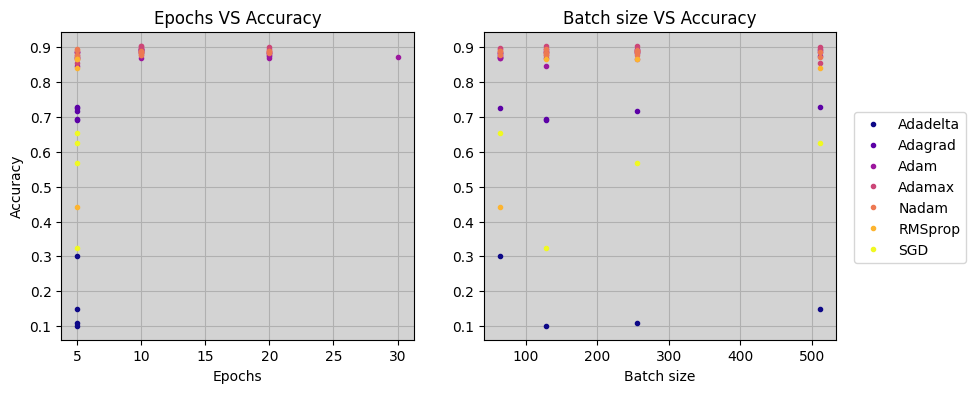

In [ ]:
def Accuracy_Epoch_batch_plot(df_results):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Create a colormap based on unique names
    unique_names = df_results['Name'].unique()
    num_colors = len(unique_names)
    colormap = plt.cm.get_cmap('plasma', num_colors)

    # Plot something in the first subplot
    for i, (name, group) in enumerate(df_results.groupby('Name')):
        axes[0].plot(group['Epochs'], group['Accuracy'], ".", label=name, color=colormap(i / (num_colors - 1)))

    axes[0].set_title('Epochs VS Accuracy')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_facecolor('lightgray')
    axes[0].grid()

    # Plot something in the second subplot
    for i, (name, group) in enumerate(df_results.groupby('Name')):
        axes[1].plot(group['Batch_size'], group['Accuracy'], ".", label=name, color=colormap(i / (num_colors - 1)))

    axes[1].set_title('Batch size VS Accuracy')
    axes[1].set_xlabel("Batch size")
    axes[1].legend(loc=(1.05, 0.25))
    axes[1].set_facecolor('lightgray')
    axes[1].grid()

    # Display the plot
    plt.show()


Accuracy_Epoch_batch_plot(df_loaded_from_drive)

In [ ]:
def Top3(results):
  accuracies = results['Accuracy']
  top3 = [np.argsort(accuracies)[-3:][::-1]][0] # [::-1] is for reverse order, such that the highest accuracy is value 1 in the top5
  for i in top3:
    print("\nModel:")
    print(results.iloc[i])


Top3(df_loaded_from_drive)


Model:
Name                             Adamax
Kwargs        {'learning_rate': 0.0005}
Batch_size                          128
Epochs                               10
Accuracy                         0.9047
Name: 55, dtype: object

Model:
Name                            Adamax
Kwargs        {'learning_rate': 0.001}
Batch_size                         256
Epochs                              10
Accuracy                        0.9032
Name: 24, dtype: object

Model:
Name                            Adamax
Kwargs        {'learning_rate': 0.001}
Batch_size                         512
Epochs                              20
Accuracy                        0.9004
Name: 46, dtype: object


# CIFAR 10 dataset

Use the 3 best models to train new models on the CIFAR 10 data set. This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. The objects are vehicles and animals.

Apply our best 3 architectures and hyperparameters (incl. optimizer).

In [ ]:
(X_train_CIFAR, y_train_CIFAR), (X_test_CIFAR, y_test_CIFAR) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
X_train_CIFAR.shape

(50000, 32, 32, 3)

[6]


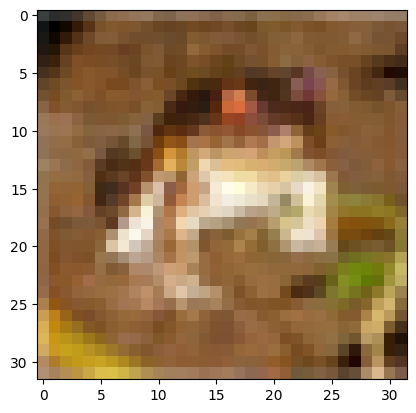

In [ ]:
# plot an instance
plt.imshow(X_train_CIFAR[0,:,:,:])
print(y_train_CIFAR[0])

In [ ]:
y_train_CIFAR.shape

(50000, 1)

Note we must change our input shape as we now have 32x32 images.

In [ ]:
convolution_model_cifar ={
    'shape':((32, 32, 3), 10),
    'output': ('dense', {'units': 10, 'activation': 'softmax'}),
    'layers':[
        ('conv', {'filters':64, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('conv', {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('conv', {'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('conv', {'filters': 256, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('conv', {'filters': 256, 'kernel_size': 3, 'activation': 'relu', 'padding': 'same'}),
        ('maxpooling', {'pool_size': (2,2)}),
        ('flatten', {}),
        ('dense', {'units': 128, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units': 64, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),

    ]
}

In [ ]:
adamax_b128_e10_le_low = test_networks_V2([convolution_model_cifar],
                       [
                        (keras.optimizers.Adamax,  {'learning_rate': 0.0005}),
                       ],

                        batch_sizes = [128],
                        epochs = [10],
                        input_shape = convolution_model_cifar['shape'][0],
                        X_train = X_train_CIFAR,
                        y_train = y_train_CIFAR,
                        X_test = X_test_CIFAR,
                        y_test = y_test_CIFAR,

                        print_steps=True,
                        time_check=True,
                       filename='none',
                        steps_per_execution=1000,
                        save=False

                       )

Could not find filename ='none'
Fitting model using optimizer.__name__ = 'Adamax'
Epochs = 10, batch size = 128
Time elapsed for optimizer.__name__ = 'Adamax', kwarg = {'learning_rate': 0.0005}, batch = 128, epoch= 10 is 6.69060906569163 min


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


In [ ]:
adamax_b256_e10_le_default = test_networks_V2([convolution_model_cifar],
                       [
                        (keras.optimizers.Adamax,  {'learning_rate': 0.001}),
                       ],

                        batch_sizes = [256],
                        epochs = [10],
                        input_shape = convolution_model_cifar['shape'][0],
                        X_train = X_train_CIFAR,
                        y_train = y_train_CIFAR,
                        X_test = X_test_CIFAR,
                        y_test = y_test_CIFAR,

                        print_steps=True,
                        time_check=True,
                       filename='none',
                        steps_per_execution=1000,
                        save=False

                       )

Could not find filename ='none'
Fitting model using optimizer.__name__ = 'Adamax'
Epochs = 10, batch size = 256
Time elapsed for optimizer.__name__ = 'Adamax', kwarg = {'learning_rate': 0.001}, batch = 256, epoch= 10 is 6.33408176501592 min


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


In [ ]:
adamax_b512_e20_le_default = test_networks_V2([convolution_model_cifar],
                       [
                        (keras.optimizers.Adamax,  {'learning_rate': 0.001}),
                       ],

                        batch_sizes = [512],
                        epochs = [20],
                        input_shape = convolution_model_cifar['shape'][0],
                        X_train = X_train_CIFAR,
                        y_train = y_train_CIFAR,
                        X_test = X_test_CIFAR,
                        y_test = y_test_CIFAR,

                        print_steps=True,
                        time_check=True,
                       filename='none',
                        steps_per_execution=1000,
                        save=False

                       )

Could not find filename ='none'
Fitting model using optimizer.__name__ = 'Adamax'
Epochs = 20, batch size = 512
Time elapsed for optimizer.__name__ = 'Adamax', kwarg = {'learning_rate': 0.001}, batch = 512, epoch= 20 is 12.236103951931 min


<ipython-input-8-923826969e64>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_data, ignore_index=True)


In [ ]:
top3_on_CIFAR = pd.concat([adamax_b128_e10_le_low,
                           adamax_b256_e10_le_default,
                           adamax_b512_e20_le_default], axis=1)

top3_on_CIFAR

,Name,Kwargs,Batch_size,Epochs,Accuracy,Name,Kwargs,Batch_size,Epochs,Accuracy,Name,Kwargs,Batch_size,Epochs,Accuracy
0,Adamax,{'learning_rate': 0.0005},128,10,0.4854,Adamax,{'learning_rate': 0.001},256,10,0.4563,Adamax,{'learning_rate': 0.001},512,20,0.5249
